# Investigation of CNN network.

When does the network perform well, when does it now?

Some ideas:

- KL-loss as a function of difference in radius
- KL-loss for each object as a function of radius
- ... as a function of x position
- ... as a function of y position


I can use a pandas dataframe and use my newly learned pandas knowledge yeay!!

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-scclevr-EncStudy-moreCNN'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
m = InvariantSlotAttention(**hps)

Using  to encode data.


In [5]:
lastIter = 16000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 16000


<All keys matched successfully>

In [6]:
import scclevr
os.sys.path.append('./../../../evaluation')
from dataset import TestDataset
import model_performance as ev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
ds = TestDataset()
X = torch.FloatTensor(ds.event_images).to(device)

In [8]:
with torch.no_grad():
    queries, att, Y_pred = m(X) 

In [9]:
mp = ev.Model_performance(ds, att)
mp.hungarian_matching()

In [10]:
mp.KL_loss()

tensor(0.0003)

# Analysis

Okay!! Let's get started with the analysis!!

In [12]:
import pandas

In [38]:
import seaborn as sns

In [14]:
df = pd.DataFrame()

In [18]:
mp.loss_KL.numpy()

array([8.5082080e-04, 1.3169093e-04, 7.8442663e-06, ..., 5.1770173e-04,
       5.0751005e-06, 2.5585100e-06], dtype=float32)

In [19]:
df["loss"] =mp.loss_KL.numpy()

In [22]:
ds.object_features

array([[[ 0.19274336,  0.31581712,  0.20575139],
        [ 0.46728778,  0.26422697,  0.20931336]],

       [[ 0.06599332, -0.16048571,  0.27169004],
        [-0.47581583, -0.03471917,  0.22540759]],

       [[-0.2895236 ,  0.3665046 ,  0.24373227],
        [ 0.43792537,  0.4566147 ,  0.1189608 ]],

       ...,

       [[-0.48958227, -0.3999218 ,  0.29032898],
        [ 0.08475371, -0.42380127,  0.28478903]],

       [[-0.3901222 , -0.08497405,  0.22343406],
        [-0.12924586,  0.45598418,  0.17115933]],

       [[-0.4352714 , -0.18687505,  0.2770639 ],
        [ 0.32188344, -0.16385613,  0.16743165]]], dtype=float32)

In [24]:
df["x1"] = ds.object_features[:, 0, 0]
df["x2"] = ds.object_features[:, 1, 0]
df["y1"] = ds.object_features[:, 0, 1]
df["y2"] = ds.object_features[:, 1, 1]
df["r1"] = ds.object_features[:, 0, 2]
df["r2"] = ds.object_features[:, 1, 2]

In [26]:
distance = np.sqrt((df["x2"]-df["x1"])**2 + (df["y2"]-df["y1"])**2)

In [30]:
overlap = [True if distance[i]-(df["r1"][i]+df["r2"][i])<0 else False for i in range(5000)]

In [32]:
df["overlap"] = overlap

In [41]:
df["r_diff"] = abs(df["r1"]-df["r2"])

In [44]:
df["pos_distance"] = distance

In [45]:
df.dtypes

loss            float32
x1              float32
x2              float32
y1              float32
y2              float32
r1              float32
r2              float32
overlap            bool
r_diff          float32
pos_distance    float32
dtype: object

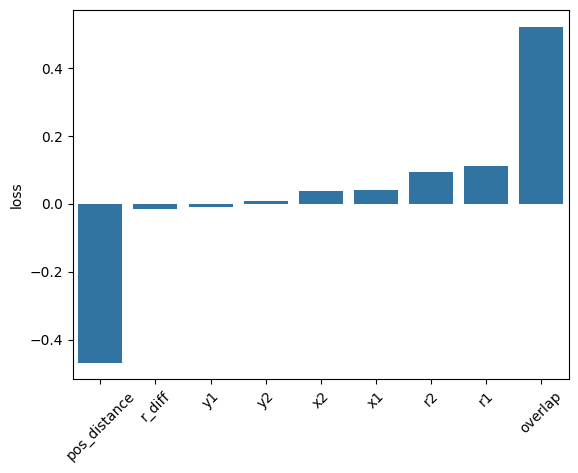

In [49]:
sns.barplot(df.corr()["loss"].drop("loss").sort_values(ascending=True))
plt.xticks(rotation=45)
plt.show()

In [55]:
df["log_loss"] = np.log10(df["loss"])

In [63]:
from matplotlib.colors import LogNorm

Show most important features in histogram

<Axes: xlabel='log_loss', ylabel='overlap'>

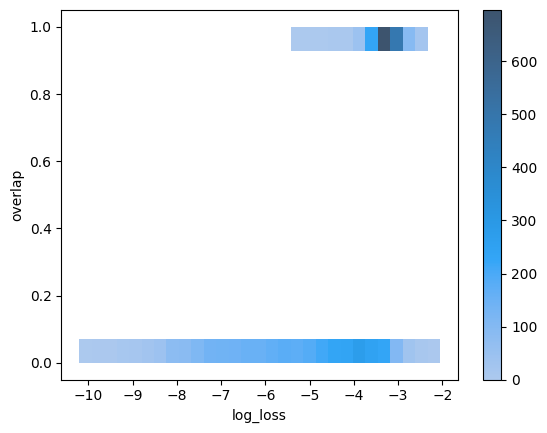

In [65]:
sns.histplot(data=df, x="log_loss", y='overlap', cbar=True)

In [69]:
pd.value_counts(df["overlap"], normalize=True)

/tmp/ipykernel_22724/4095561388.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df["overlap"], normalize=True)


overlap
False    0.6822
True     0.3178
Name: proportion, dtype: float64

<Axes: xlabel='log_loss', ylabel='r1'>

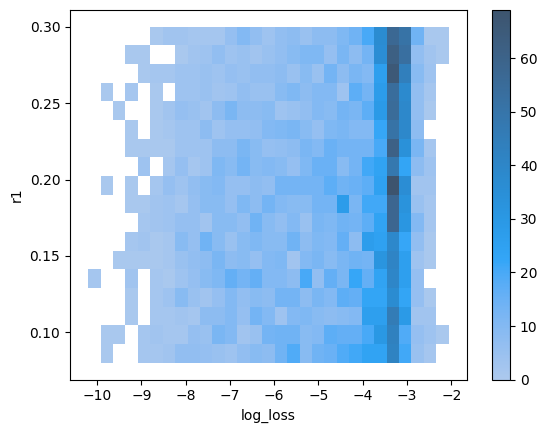

In [71]:
sns.histplot(data=df, x="log_loss", y='r1', cbar=True)

<Axes: xlabel='log_loss', ylabel='r2'>

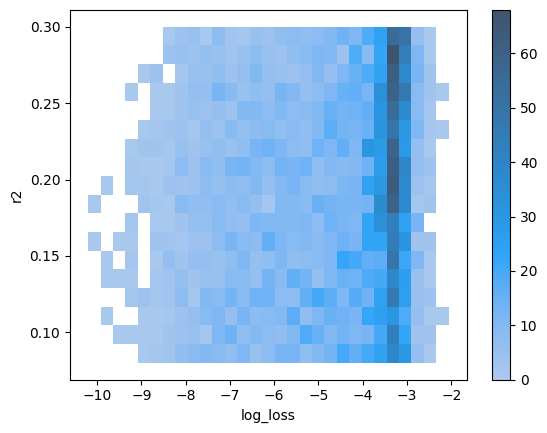

In [67]:
sns.histplot(data=df, x="log_loss", y='r2', cbar=True)